# Tiny ImageNet

Tiny ImageNet is a smaller subset of the ImageNet dataset designed for quick prototyping and experimentation. It is widely used in deep learning research and education due to its manageable size and complexity.

## Key Features
- **Number of Classes**: 200 classes, each corresponding to a specific object category.
- **Image Size**: All images are resized to 64x64 pixels, making it computationally efficient to train models.
- **Dataset Structure**:
  - **Training Set**: 100,000 images (500 per class).
  - **Validation Set**: 10,000 images (50 per class).
  - **Test Set**: 10,000 images (unlabeled).


## Dataset Organization
Tiny ImageNet is organized into folders:
- `train/`: Contains subfolders for each class with images for training.
- `val/`: Contains validation images and a CSV file `val_annotations.txt` with image-label mappings.
- `test/`: Contains test images (no labels provided).


https://www.kaggle.com/c/tiny-imagenet

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import zipfile
import tensorflow as tf
import tensorflow.keras.backend as K
import itertools

from functools import partial
from tensorflow.keras import mixed_precision
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
mixed_precision.set_global_policy('mixed_float16')

In [5]:
RANDOM_SEED = 42
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [7]:
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
response = requests.get(url, stream=True)

In [8]:
with open("tiny-imagenet-200.zip", "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
        f.write(chunk)

In [9]:
path_to_zip_file = "tiny-imagenet-200.zip"
directory_to_extract_to = "./"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [10]:
default_path = "tiny-imagenet-200"
path_to_train_files = default_path + "/train"  # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/train"
path_to_val_files = default_path + "/val/images" # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/val/images"
path_to_test_files = default_path + "/test/images" # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/test/images"

In [11]:
unique_tiny_labels = os.listdir(path_to_train_files)

In [12]:
unique_labels = pd.read_csv(default_path + "/words.txt", sep='\t', 
                header=None, names=["class_id", "label"])
unique_labels.class_id = unique_labels.class_id.astype(str)
unique_labels = unique_labels.loc[unique_labels['class_id'].isin(unique_tiny_labels)]
unique_labels.sort_values(by="label", inplace=True)
unique_labels.reset_index(inplace=True, drop=True)
unique_labels = tf.convert_to_tensor(unique_labels)

In [13]:
train_files_pattern = os.path.join(path_to_train_files, '*', 'images', '*.JPEG')
train_ds_files = tf.data.Dataset.list_files(train_files_pattern, shuffle=True, seed=RANDOM_SEED)

In [14]:
val_files_pattern = os.path.join(path_to_val_files, '*.JPEG')
test_files_pattern = os.path.join(path_to_test_files, '*.JPEG')

val_ds_files = tf.data.Dataset.list_files(val_files_pattern)
test_ds_files = tf.data.Dataset.list_files(test_files_pattern)

In [15]:
val_labels = pd.read_csv(default_path + "/val/val_annotations.txt",  sep='\t', 
                header=None, names=["file_name", "class_id", "box_coord_1", "box_coord_2", "box_coord_3", "box_coord_4"])

In [16]:
val_labels = tf.convert_to_tensor(val_labels[["file_name", "class_id"]])

In [17]:
@tf.function
def load_image(filename, ds_type="train"):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    parts = tf.strings.split(filename, os.sep)

    if ds_type == "train" or ds_type == "validation":
        if ds_type == "train":
            label = parts[-3] 

        else:
            file_basename = parts[-1]  
            label = val_labels[tf.argmax(tf.equal(val_labels[:, 0], file_basename)), 1]

        #label = unique_labels[tf.argmax(tf.equal(unique_labels[:, 0], label)), 1] # if string label
        label = tf.argmax(tf.equal(unique_labels[:, 0], label)) # if as int
        return image, label

    else:
        return image


In [18]:
@tf.function
def apply_data_augmentation(image, label, augmentation_type=None):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    
    if augmentation_type == 'randaugment':
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        
        max_shift = 4
        image = tf.image.resize_with_crop_or_pad(image, IMG_HEIGHT + max_shift, IMG_WIDTH + max_shift)
        image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    image = tf.cast(image, tf.float32)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [19]:
def configure_performance(ds, apply_augmentation=True, augmentation_type=None):
    if apply_augmentation:
        ds = ds.cache()
        ds = ds.shuffle(10000)
        ds = ds.map(lambda img, label: apply_data_augmentation(img, label, augmentation_type=augmentation_type), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:            
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [20]:
train_ds = configure_performance(train_ds_files.map(lambda fname: load_image(fname),num_parallel_calls=tf.data.experimental.AUTOTUNE), apply_augmentation=True, augmentation_type=None)
val_ds = configure_performance(val_ds_files.map(lambda fname: load_image(fname, ds_type="validation"), num_parallel_calls=tf.data.experimental.AUTOTUNE), apply_augmentation=False)

In [21]:
image_batch, labels_batch = next(iter(train_ds))

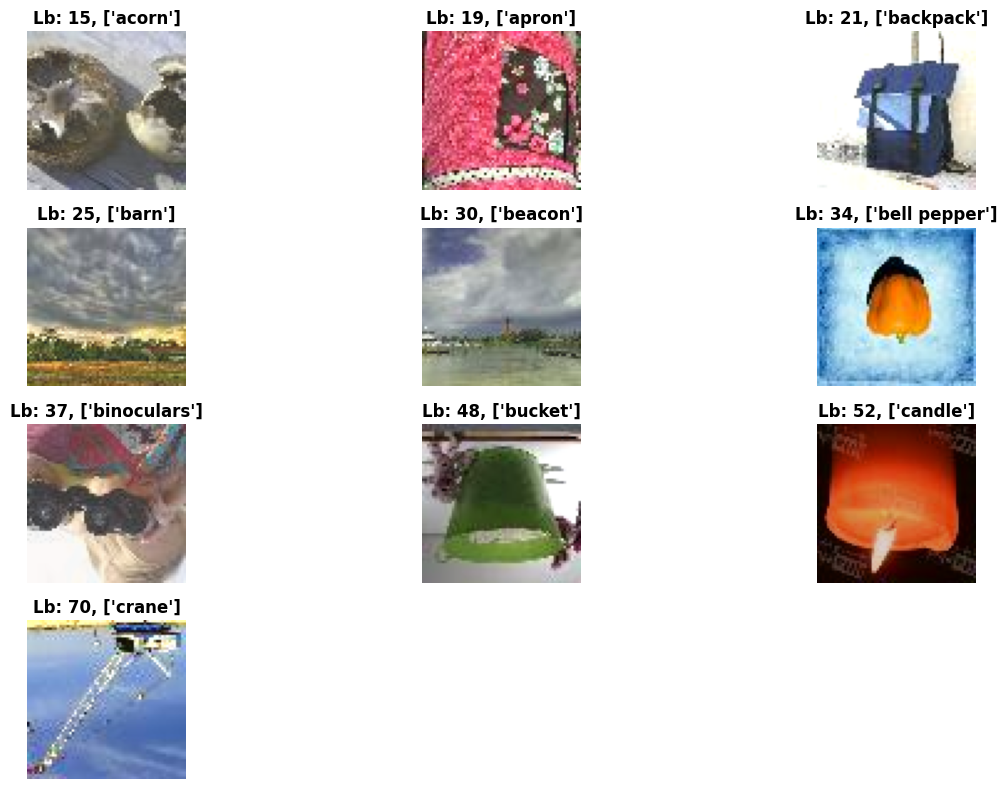

In [22]:
plt.figure(figsize=(12, 8))

for idx, label in enumerate(np.unique(labels_batch.numpy().astype(int).tolist())[:10]):
  ax = plt.subplot(4, 3, idx + 1)
  label_idx = tf.argmax(labels_batch.numpy() == label).numpy()
  plt.imshow(tf.cast(image_batch[label_idx], tf.float32))
  plt.title(f"Lb: {label}, {unique_labels[label].numpy()[1].decode('utf-8').split(',')[0:1]}", fontweight="bold")
  plt.axis("off")

plt.tight_layout()
plt.show()

## Using a State-of-Art CNN Architecture

ConvNext V1:
https://arxiv.org/pdf/2201.03545

In [23]:
class StochasticDepth(tf.keras.layers.Layer):
    """ Aka Drop Path """
    def __init__(self, drop_path, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_path = drop_path

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path
            shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / tf.cast(keep_prob, tf.float16)) * tf.cast(random_tensor, tf.float16)
        return x

### Drop Path example

In [24]:
random_pic = next(iter(train_ds))
sample_img, sample_label = random_pic[0][0], random_pic[1][0]

In [25]:
drop_path = 0.3
keep_prob = 1 - drop_path
shape = (tf.shape(sample_img)[0],) + (1,) * (len(sample_img.shape) - 1)
random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
random_tensor = tf.floor(random_tensor)

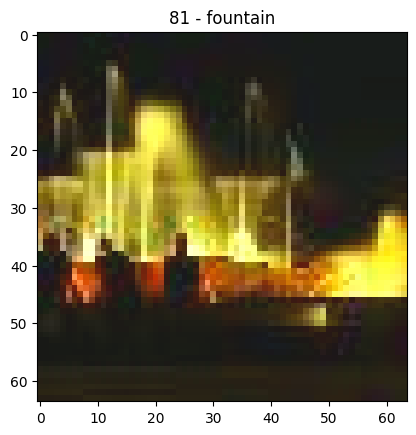

In [26]:
plt.imshow(tf.cast(sample_img, tf.float32))
plt.title(f"{sample_label} - {unique_labels[int(sample_label.numpy())][1].numpy().decode('utf-8')}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4285715].


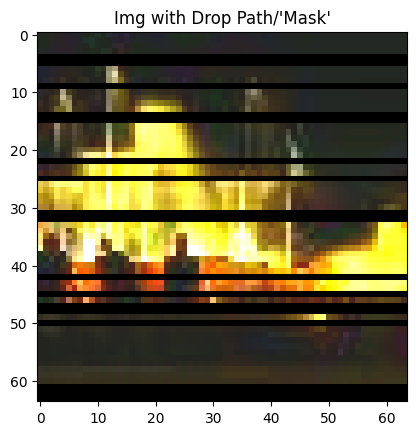

In [27]:
plt.imshow((tf.cast(sample_img, tf.float32) / keep_prob) * random_tensor)
plt.title("Img with Drop Path/'Mask'")
plt.show()

In [28]:
class Block(tf.keras.Model):
    """ConvNeXt block.

    References:
        (1) https://arxiv.org/pdf/2201.03545
        (2) https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
        (3) https://github.com/sayakpaul/ConvNeXt-TF/blob/main/models/convnext_tf.py
    """

    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.dim = dim
        if layer_scale_init_value > 0:
            self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,), tf.float16))
        else:
            self.gamma = None
        self.dw_conv_1 = tf.keras.layers.Conv2D( 
            filters=dim, kernel_size=7, padding="same", groups=dim ## depthwise conv
        )
        # Groups: A positive int specifying the number of groups in which the input is split along the channel axis. 
        # Each group is convolved separately with filters // groups filters. The output is the concatenation of all the groups results along the channel axis. 
        # Input channels and filters must both be divisible by groups.

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.pw_conv_1 = tf.keras.layers.Dense(4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act_fn = tf.keras.layers.Activation("gelu") 
        self.pw_conv_2 = tf.keras.layers.Dense(dim)
        self.drop_path = (
            StochasticDepth(drop_path)
            if drop_path > 0.0
            else tf.keras.layers.Activation("linear")
        )

    def call(self, inputs):
        x = inputs

        x = self.dw_conv_1(x)
        x = self.layer_norm(x)
        x = self.pw_conv_1(x)
        x = self.act_fn(x)
        x = self.pw_conv_2(x)

        if self.gamma is not None:
            x = self.gamma * x

        return inputs + self.drop_path(x) # Residual Connection


In [29]:
def return_convnext_model(
    model_name="convnext_tiny",
    input_shape=(224, 224, 3),
    num_classes=200,
    depths=[3, 3, 27, 3],
    dims=[128, 256, 512, 1024],
    drop_path_rate=0.0,
    layer_scale_init_value=1e-6,
    ) -> tf.keras.Model:
    
    """Implements ConvNeXt Base given configurations. convnext_base_1k_224

    References:
        (1) https://arxiv.org/abs/2201.03545
        (2) https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
        (3) https://github.com/sayakpaul/ConvNeXt-TF/blob/main/models/convnext_tf.py
    """

    inputs = tf.keras.layers.Input(input_shape)
    stem = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(dims[0], kernel_size=4, strides=4),
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
        ],
        name="stem",
    )

    downsample_layers = []
    downsample_layers.append(stem)
    for i in range(3):
        downsample_layer = tf.keras.Sequential(
            [
                tf.keras.layers.LayerNormalization(epsilon=1e-6),
                tf.keras.layers.Conv2D(dims[i + 1], kernel_size=2, strides=2),
            ],
            name=f"downsampling_block_{i}",
        )
        downsample_layers.append(downsample_layer)

    stages = []  # 4 feature resolution stages, each consisting of multiple residual blocks
    dp_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(4): 
        stage = tf.keras.Sequential(
            [
                *[
                    Block(
                        dim=dims[i],
                        drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value,
                        name=f"convnext_block_{i}_{j}",
                    )
                    for j in range(depths[i])
                ]
            ],
            name=f"convnext_stage_{i}",
        )
        stages.append(stage)
        cur += depths[i]

    x = inputs
    for i in range(len(stages)):
        x = downsample_layers[i](x)
        x = stages[i](x)

    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    outputs = tf.keras.layers.Dense(num_classes, name="classification_head")(x)

    return tf.keras.Model(inputs, outputs, name=model_name)

In [27]:
model = return_convnext_model(drop_path_rate=0.5)

In [ ]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [29]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0,
    warmup_target=4e-3,
    warmup_steps=500,
    decay_steps=6825,
    alpha=0.0
)

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.05,use_ema=True,ema_momentum=0.999),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
REQUIRED_HEIGHT = 224
REQUIRED_WIDTH = 224

In [32]:
@tf.function
def resize_img(img, label):
    return tf.cast(tf.image.resize(img, (REQUIRED_HEIGHT, REQUIRED_WIDTH), method=tf.image.ResizeMethod.BICUBIC), tf.float16), label

In [33]:
train_ds = train_ds.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
)

In [ ]:
## Suddenly, I dont have enough capacity to run the pretrain process (would be many days on an A100)

# Fine-tuning ConvNextBase

In [34]:
del model
K.clear_session()

In [35]:
REQUIRED_HEIGHT = 224
REQUIRED_WIDTH = 224

In [35]:
@tf.function
def resize_img(img, label):
    img = tf.image.resize(img, (REQUIRED_HEIGHT, REQUIRED_WIDTH), method=tf.image.ResizeMethod.BICUBIC)
    img = tf.clip_by_value(img * 255, 0, 255)
    img = tf.round(img)
    img = tf.cast(img, tf.uint8)
    return img, label

In [37]:
train_ds_unscld = train_ds.map(lambda image, label: resize_img(image, label), num_parallel_calls=tf.data.AUTOTUNE)
val_ds_unscld = val_ds.map(lambda image, label: resize_img(image, label), num_parallel_calls=tf.data.AUTOTUNE)

In [38]:
base_model = tf.keras.applications.ConvNeXtBase(input_shape=(REQUIRED_HEIGHT, REQUIRED_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               include_preprocessing=True,
                                                   )

In [39]:
base_model.trainable = False

In [40]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(REQUIRED_HEIGHT, REQUIRED_WIDTH, 3)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(.3))
model.add(tf.keras.layers.Dense(200, activation='softmax'))

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
initial_epochs = 5

history_phase1 = model.fit(
    train_ds_unscld,
    validation_data=val_ds_unscld,
    epochs=initial_epochs
)

Epoch 1/5


   3/3125 ━━━━━━━━━━━━━━━━━━━━ 2:05 40ms/step - accuracy: 0.0035 - loss: 5.4545       

I0000 00:00:1737447912.242332   10408 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5775 - loss: 2.0301

E0000 00:00:1737448042.852733   10406 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737448043.010073   10406 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 165s 43ms/step - accuracy: 0.5776 - loss: 2.0298 - val_accuracy: 0.8607 - val_loss: 0.5337
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 115s 37ms/step - accuracy: 0.7225 - loss: 1.1027 - val_accuracy: 0.8640 - val_loss: 0.5267
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 115s 37ms/step - accuracy: 0.7379 - loss: 1.0321 - val_accuracy: 0.8625 - val_loss: 0.5245
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 115s 37ms/step - accuracy: 0.7451 - loss: 0.9932 - val_accuracy: 0.8655 - val_loss: 0.5253
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 115s 37ms/step - accuracy: 0.7471 - loss: 0.9822 - val_accuracy: 0.8630 - val_loss: 0.5295


In [43]:
base_model.trainable = True
unfreeze_last_n_layers = 50

for layer in base_model.layers[:-unfreeze_last_n_layers]:
    layer.trainable = False

In [44]:
fine_tune_epochs = 5
initial_lr = 1e-4
fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

In [45]:
model.compile(
    optimizer=fine_tune_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_ds_unscld,
    validation_data=val_ds_unscld,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history_phase1.epoch[-1] + 1
)

Epoch 6/10


E0000 00:00:1737448546.833942   10408 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737448546.988399   10408 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 198s 51ms/step - accuracy: 0.7720 - loss: 0.8819 - val_accuracy: 0.8792 - val_loss: 0.4503
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 152s 49ms/step - accuracy: 0.8321 - loss: 0.6185 - val_accuracy: 0.8801 - val_loss: 0.4514
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 152s 48ms/step - accuracy: 0.8718 - loss: 0.4572 - val_accuracy: 0.8784 - val_loss: 0.4764
Epoch 9/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 151s 48ms/step - accuracy: 0.9037 - loss: 0.3385 - val_accuracy: 0.8758 - val_loss: 0.5061
Epoch 10/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 151s 48ms/step - accuracy: 0.9292 - loss: 0.2457 - val_accuracy: 0.8753 - val_loss: 0.5250


In [46]:
acc1 = history_phase1.history['accuracy']
val_acc1 = history_phase1.history['val_accuracy']
loss1 = history_phase1.history['loss']
val_loss1 = history_phase1.history['val_loss']

acc2 = history_phase2.history['accuracy']
val_acc2 = history_phase2.history['val_accuracy']
loss2 = history_phase2.history['loss']
val_loss2 = history_phase2.history['val_loss']

In [47]:
acc = acc1 + acc2
val_acc = val_acc1 + val_acc2
loss = loss1 + loss2
val_loss = val_loss1 + val_loss2

phase1_end = len(acc1) 

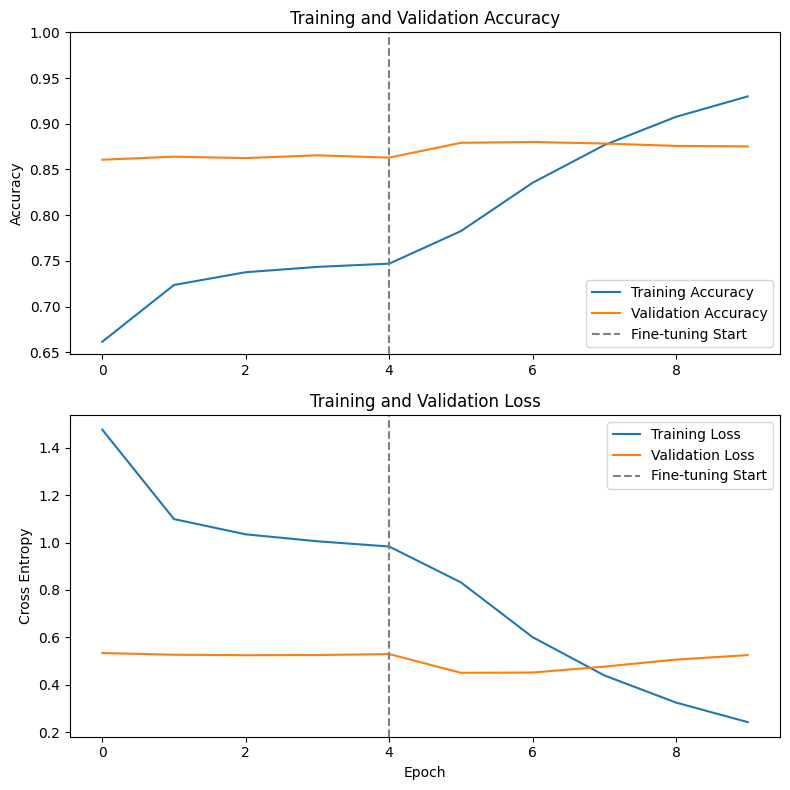

In [48]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=phase1_end - 1, color='gray', linestyle='--', label='Fine-tuning Start')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=phase1_end - 1, color='gray', linestyle='--', label='Fine-tuning Start')

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.savefig('finetuning.png')
plt.show()

### Predictions on validation dataset

In [49]:
predictions = model.predict(val_ds_unscld)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step


In [50]:
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.float16)
prediction_confidence = tf.reduce_max(predictions, axis=1)

In [51]:
validation_imgs = []
actual_labels = []
for imgs, labels in val_ds_unscld:
    validation_imgs.extend(imgs.numpy())
    actual_labels.extend(labels.numpy())

In [52]:
validation_imgs = tf.convert_to_tensor(np.array(validation_imgs))
actual_labels = tf.convert_to_tensor(np.array(actual_labels))

In [53]:
cm = confusion_matrix(actual_labels, predicted_labels)
accuracy = accuracy_score(actual_labels, predicted_labels)

In [54]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")


Macro-average F1-score: 0.8756


In [55]:
print(f"Mean Interclass Precision: {np.round(np.mean(precision), 4)}")
print(f"Mean Interclass Recall: {np.round(np.mean(recall), 4)}")
print(f"Top-1 Accuracy: {accuracy}")

Mean Interclass Precision: 0.8805
Mean Interclass Recall: 0.8753
Top-1 Accuracy: 0.8753


In [60]:
predicted_labels = tf.cast(predicted_labels, tf.int64)

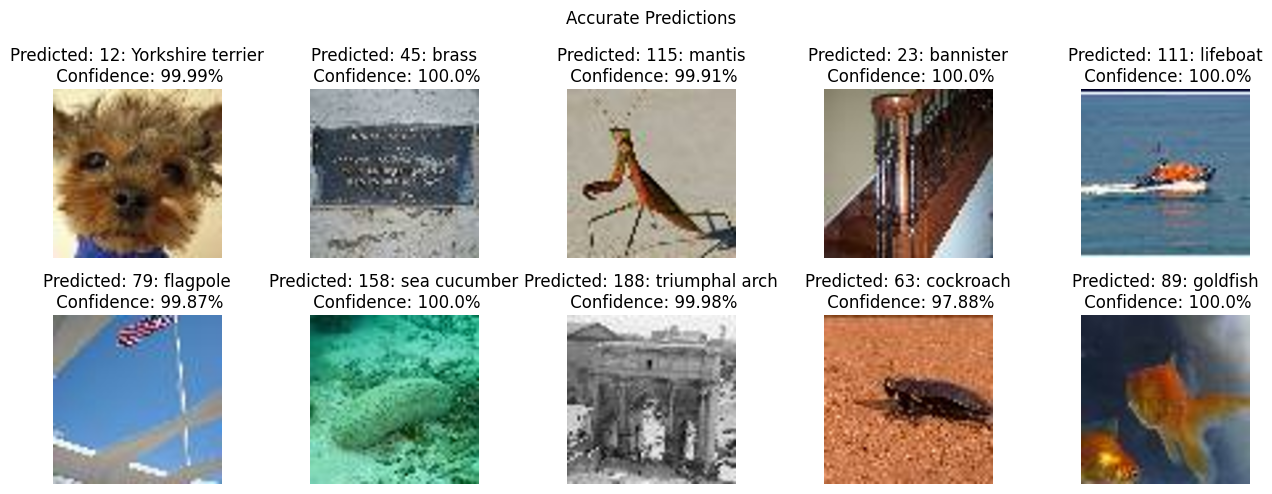

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels==actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted: {predicted_labels[random_index].numpy()}: {unique_labels[predicted_labels[random_index].numpy()][1].numpy().decode('utf8').split(',')[0]}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.savefig("accurate_val_predictions.png")
plt.show()

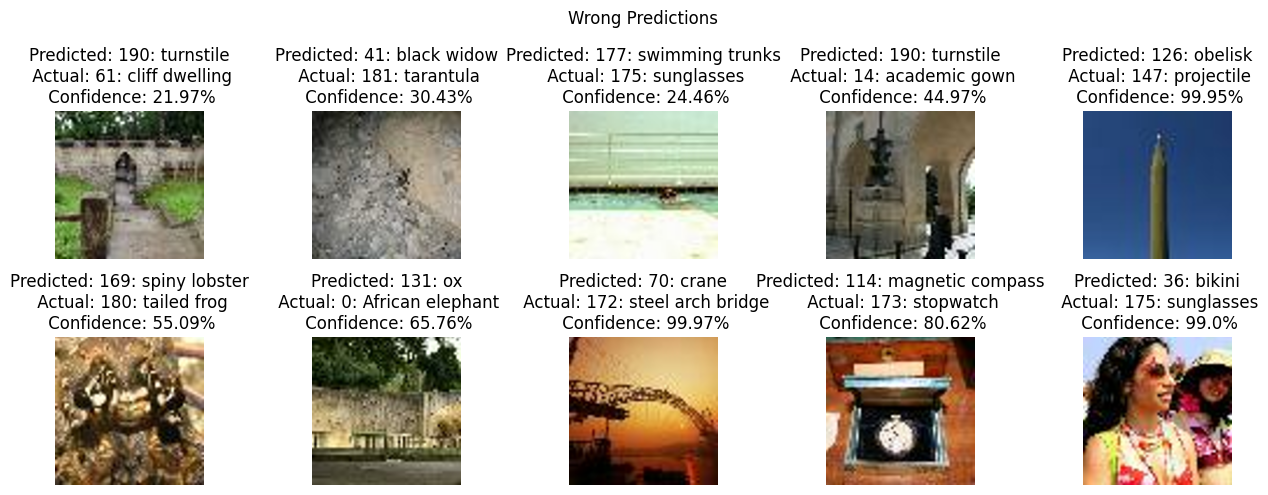

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Wrong Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels!=actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted: {predicted_labels[random_index].numpy()}: {unique_labels[predicted_labels[random_index].numpy()][1].numpy().decode('utf8').split(',')[0]}\n Actual: {actual_labels[random_index]}: {unique_labels[actual_labels[random_index].numpy()][1].numpy().decode('utf8').split(',')[0]}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.savefig("wrong_val_predictions.png")
plt.show()

### Predictions on test dataset

In [30]:
all_files_ds = train_ds_files.concatenate(val_ds_files)

In [31]:
train_ds = configure_performance(all_files_ds.map(lambda fname: load_image(fname),num_parallel_calls=tf.data.experimental.AUTOTUNE), apply_augmentation=True, augmentation_type=None)
test_ds = configure_performance(test_ds_files.map(lambda fname: load_image(fname, ds_type="test"), num_parallel_calls=tf.data.experimental.AUTOTUNE), apply_augmentation=False, augmentation_type=None)

In [ ]:
del model, base_model
K.clear_session()

In [33]:
REQUIRED_HEIGHT = 224
REQUIRED_WIDTH = 224

In [34]:
@tf.function
def resize_test_img(img):
    img = tf.image.resize(img, (REQUIRED_HEIGHT, REQUIRED_WIDTH), method=tf.image.ResizeMethod.BICUBIC)
    img = tf.clip_by_value(img * 255, 0, 255)
    img = tf.round(img)
    img = tf.cast(img, tf.uint8)
    return img

In [36]:
train_ds_unscld = train_ds.map(lambda image, label: resize_img(image, label), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_unscld = test_ds.map(lambda image: resize_test_img(image), num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
base_model = tf.keras.applications.ConvNeXtBase(input_shape=(REQUIRED_HEIGHT, REQUIRED_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               include_preprocessing=True,
                                                   )

In [38]:
base_model.trainable = False

In [39]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(REQUIRED_HEIGHT, REQUIRED_WIDTH, 3)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(.3))
model.add(tf.keras.layers.Dense(200, activation='softmax'))

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
initial_epochs = 5

history_phase1 = model.fit(
    train_ds_unscld,
    epochs=initial_epochs
)

Epoch 1/5


   7/3438 ━━━━━━━━━━━━━━━━━━━━ 1:16 22ms/step - accuracy: 0.0023 - loss: 5.5913      

I0000 00:00:1737452296.260060   27774 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3437/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5777 - loss: 2.0332

E0000 00:00:1737452373.870451   27773 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737452374.028496   27773 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3438/3438 ━━━━━━━━━━━━━━━━━━━━ 121s 25ms/step - accuracy: 0.5778 - loss: 2.0329
Epoch 2/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 64s 19ms/step - accuracy: 0.7011 - loss: 1.1834
Epoch 3/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 64s 19ms/step - accuracy: 0.7162 - loss: 1.1100
Epoch 4/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 64s 19ms/step - accuracy: 0.7203 - loss: 1.0811
Epoch 5/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 64s 19ms/step - accuracy: 0.7246 - loss: 1.0600


In [42]:
base_model.trainable = True
unfreeze_last_n_layers = 50

for layer in base_model.layers[:-unfreeze_last_n_layers]:
    layer.trainable = False

In [43]:
fine_tune_epochs = 5
initial_lr = 1e-4
fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

In [44]:
model.compile(
    optimizer=fine_tune_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_ds_unscld,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history_phase1.epoch[-1] + 1
)

Epoch 6/10


E0000 00:00:1737452666.603311   27775 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737452666.761332   27775 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3437/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7544 - loss: 0.9406

E0000 00:00:1737452906.310911   27775 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737452906.468744   27775 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3438/3438 ━━━━━━━━━━━━━━━━━━━━ 283s 70ms/step - accuracy: 0.7543 - loss: 0.9406
Epoch 7/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 221s 64ms/step - accuracy: 0.8152 - loss: 0.6673
Epoch 8/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 221s 64ms/step - accuracy: 0.8580 - loss: 0.5005
Epoch 9/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 221s 64ms/step - accuracy: 0.8916 - loss: 0.3723
Epoch 10/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 221s 64ms/step - accuracy: 0.9172 - loss: 0.2851
